In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, datasets
from tqdm import tqdm
import numpy as np
from torch.amp import GradScaler, autocast
import timm
from timm.data import Mixup
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score
from PIL import Image
from timm.models.convnext import ConvNeXtBlock
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split

c:\Users\10955\anaconda3\envs\vitiligo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


self-supervied trainging

In [ ]:
class Config:
    root_dir = "../"
    data_dir = '../../../../datasets/data.csv'
    img_size = 224
    patch_size = 8
    mask_ratio = 0.75
    batch_size = 8
    weight_decay = 0.05
    device = "cuda" if torch.cuda.is_available() else "cpu"
    num_epochs = 30
    learning_rate = 1e-4
    patience = 10 
    save_dir = '../checkpoints/v5'
    checkpoint_path = '../../../../outputs/checkpoints/proposed/pytorch_model.bin'
    resume_training = False
    augment_ratio = 4
    def __init__(self):
        os.makedirs(self.save_dir, exist_ok=True)

config = Config()



In [ ]:
import random
import matplotlib.pyplot as plt

class VitiligoDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.grouped = self.data.groupby(['pair_id', 'stability'])
        self.root_dir = root_dir

    def __len__(self):
        return len(self.grouped.groups)

    def __getitem__(self, idx):
        pair_id, stability = list(self.grouped.groups.keys())[idx]
        pairs = self.grouped.get_group((pair_id, stability))
        clinic = pairs[pairs['image_type'] == 'clinic']
        wood = pairs[pairs['image_type'] == 'wood']
        clinic_path = self.root_dir + clinic['image_path'].values[0]
        wood_path = self.root_dir + wood['image_path'].values[0]
        clinic_image = Image.open(clinic_path).convert('RGB')
        wood_image = Image.open(wood_path).convert('RGB')
        if self.transform:
            clinic_image = self.transform(clinic_image)
            wood_image = self.transform(wood_image)
        label = 1 if stability == 'stable' else 0
        label = torch.tensor(label, dtype=torch.long)
        return clinic_image, wood_image, label


class AugmentedMixedDataset(Dataset):
    def __init__(self, original_dataset, transform, original_transform, augment_ratio=4):

        self.original_dataset = original_dataset
        self.transform = transform  
        self.original_transform = original_transform  
        self.augment_ratio = augment_ratio
        self.original_indices = list(range(len(original_dataset)))
        self.augmented_indices = list(range(len(original_dataset))) * augment_ratio
    
    def __len__(self):
        return len(self.original_indices) + len(self.augmented_indices)
    
    def __getitem__(self, idx):
        is_original = idx < len(self.original_indices)
        
        if is_original:
            idx_in_original = idx
            c_img, w_img, label = self.original_dataset[idx_in_original]
            c_img = self.original_transform(c_img)
            w_img = self.original_transform(w_img)
        else:
            idx_in_augmented = idx - len(self.original_indices)
            original_idx = self.augmented_indices[idx_in_augmented]
            c_img, w_img, label = self.original_dataset[original_idx]
            c_img_pil = transforms.ToPILImage()(c_img)
            w_img_pil = transforms.ToPILImage()(w_img)
            c_img_aug, w_img_aug = self.transform(c_img_pil, w_img_pil)
            c_img, w_img = c_img_aug, w_img_aug
        
        return c_img, w_img, label


class DualImageTransform:
    def __init__(self, transform):
        self.transform = transform
    
    def __call__(self, img1, img2):
        seed = random.randint(0, 2**32 - 1)
        for t in self.transform.transforms:
            random.seed(seed)
            img1 = t(img1)
            random.seed(seed)
            img2 = t(img2)
        return img1, img2


class LabColorTransform:
    def __init__(self, brightness_scale=0.1, a_scale=0.2, b_scale=0.2, p=0.5):
        self.brightness_scale = brightness_scale
        self.a_scale = a_scale
        self.b_scale = b_scale
        self.p = p
    
    def __call__(self, img):
        if random.random() > self.p:
            return img
        
        lab_img = img.convert('LAB')
        lab_array = np.array(lab_img)
        L, a, b = lab_array[:, :, 0], lab_array[:, :, 1], lab_array[:, :, 2]
        
        brightness_shift = random.uniform(-self.brightness_scale, self.brightness_scale)
        L = np.clip(L + brightness_shift * 100, 0, 100)
        
        a_shift = random.uniform(-self.a_scale, self.a_scale)
        a = np.clip(a + a_shift * 127, -128, 127)
        
        b_shift = random.uniform(-self.b_scale, self.b_scale)
        b = np.clip(b + b_shift * 127, -128, 127)
        
        lab_array[:, :, 0] = L
        lab_array[:, :, 1] = a
        lab_array[:, :, 2] = b
        return Image.fromarray(lab_array, mode='LAB').convert('RGB')


def create_timm_transforms(backbone, train=True):

    pretrained_cfg = backbone.pretrained_cfg if hasattr(backbone, 'pretrained_cfg') else {}

    data_config = timm.data.resolve_data_config(pretrained_cfg, verbose=False)

    
    if train:

        transform = timm.data.create_transform(
            input_size=data_config['input_size'],
            is_training=True,
            color_jitter=data_config.get('color_jitter', 0.4),
            auto_augment=data_config.get('auto_augment', None),
            re_prob=data_config.get('reprob', 0.25),
            re_mode=data_config.get('remode', 'pixel'),
            re_count=data_config.get('recount', 1),
            mean=data_config.get('mean', timm.data.constants.IMAGENET_DEFAULT_MEAN),
            std=data_config.get('std', timm.data.constants.IMAGENET_DEFAULT_STD),
        )
    else:

        transform = timm.data.create_transform(
            input_size=data_config['input_size'],
            is_training=False,
            mean=data_config.get('mean', timm.data.constants.IMAGENET_DEFAULT_MEAN),
            std=data_config.get('std', timm.data.constants.IMAGENET_DEFAULT_STD),
        )
    return transform


def get_augmentation_transform(timm_train_transform, img_size=None):

    if img_size is None:
        img_size = timm_train_transform.transforms[0].size[0]  
    
    timm_transform_list = []
    for t in timm_train_transform.transforms:
        if isinstance(t, (transforms.ToTensor, transforms.Normalize)):
            break
        timm_transform_list.append(t)
    transform = transforms.Compose([
        *timm_transform_list,
        transforms.RandomRotation(degrees=15),
        LabColorTransform(),  
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
        transforms.RandomApply([transforms.RandomAdjustSharpness(sharpness_factor=2)], p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=timm.data.constants.IMAGENET_DEFAULT_MEAN,
            std=timm.data.constants.IMAGENET_DEFAULT_STD
        )
    ])
    return transform



def visualize_dataset(dataset, num_samples=8, figsize_per_sample=(4, 4), dpi=100):

 
    total_figsize = (figsize_per_sample[0] * 2, figsize_per_sample[1] * num_samples)
    
    plt.figure(figsize=total_figsize, dpi=dpi)
    for i in range(num_samples):
        c_img, w_img, label = dataset[i]
        
 
        mean = np.array(timm.data.constants.IMAGENET_DEFAULT_MEAN)
        std = np.array(timm.data.constants.IMAGENET_DEFAULT_STD)
        c_img_np = c_img.permute(1, 2, 0).cpu().numpy()
        w_img_np = w_img.permute(1, 2, 0).cpu().numpy()
        
        c_img_np = c_img_np * std + mean
        w_img_np = w_img_np * std + mean
        c_img_np = np.clip(c_img_np, 0, 1)
        w_img_np = np.clip(w_img_np, 0, 1)
        
    
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(c_img_np)
        plt.title(f'Clinic Image\nLabel: {label.item()}', fontsize=12)
        plt.axis('off')
        
   
        plt.subplot(num_samples, 2, 2*i+2)
        plt.imshow(w_img_np)
        plt.title(f'Wood Lamp Image\nLabel: {label.item()}', fontsize=12)
        plt.axis('off')
    
   
    plt.tight_layout(pad=2.0)

backbone = timm.create_model("convnextv2_tiny", checkpoint_path=Config.checkpoint_path)
    
original_dataset = VitiligoDataset(root_dir=Config.root_dir, csv_file=Config.data_dir)
print(f"Original datasize: {len(original_dataset)} pairs")


train_size = int(0.8 * len(original_dataset))
val_size = len(original_dataset) - train_size
train_dataset_original, val_dataset_original = torch.utils.data.random_split(
    original_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)
print(f"train_dataset_original: {len(train_dataset_original)} pairs")
print(f"val_dataset_original: {len(val_dataset_original)} pairs")


timm_train_transform = create_timm_transforms(backbone, train=True)
timm_val_transform = create_timm_transforms(backbone, train=False)


train_augment_transform = get_augmentation_transform(timm_train_transform)
train_original_transform = timm_val_transform  



train_dataset = AugmentedMixedDataset(
    original_dataset=train_dataset_original,
    transform=DualImageTransform(train_augment_transform),
    original_transform=train_original_transform,
    augment_ratio=Config.augment_ratio)

print(f"train_dataset: {len(train_dataset)} pairs")
val_dataset = val_dataset_original
val_dataset.dataset.transform = timm_val_transform

train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Config.batch_size, shuffle=False)




Original datasize: 605 pairs
train_dataset_original: 484 pairs
val_dataset_original: 121 pairs
train_dataset: 2420 pairs


dataloader

In [4]:
from collections import Counter




train_labels = []
for _, _, label in train_dataset:
    train_labels.append(label.item())

class_counts = Counter(train_labels)
total_samples = len(train_labels)
class_percentages = {cls: count / total_samples * 100 for cls, count in class_counts.items()}


print("Distribution:")
for cls, count in class_counts.items():
    print(f"Classes {cls}: {count} samples ({class_percentages[cls]:.2f}%)")


Distribution:
Classes 1: 1255 samples (51.86%)
Classes 0: 1165 samples (48.14%)


Model

In [5]:
import timm
import torch


model = timm.create_model(
    "convnextv2_tiny",
    pretrained=False,
    features_only=True,
    out_indices=[0, 2, 3]
)


dummy_input = torch.randn(1, 3, 224, 224)


features = model(dummy_input)


for i, feat in enumerate(features):
    print(f"Stage {i} output shape: {feat.shape}")

Stage 0 output shape: torch.Size([1, 96, 56, 56])
Stage 1 output shape: torch.Size([1, 384, 14, 14])
Stage 2 output shape: torch.Size([1, 768, 7, 7])


In [ ]:
os.environ.pop('HTTP_PROXY', None)
os.environ.pop('HTTPS_PROXY', None)



class MaskGenerator:
    def __init__(self, input_size, patch_size, mask_ratio):
        self.input_size = input_size
        self.patch_size = patch_size
        self.mask_ratio = mask_ratio
        self.num_patches = (input_size // patch_size) ** 2
        self.patch_h = input_size // patch_size
        self.patch_w = input_size // patch_size

    def __call__(self, batch_size=1, device=torch.device("cpu")):
        num_masked = int(self.mask_ratio * self.num_patches)
        mask = torch.ones(batch_size, self.num_patches, dtype=torch.bool, device=device)
        for i in range(batch_size):
            indices = torch.randperm(self.num_patches, device=device)[:num_masked]
            mask[i, indices] = False
        mask = mask.view(batch_size, 1, self.patch_h, self.patch_w)
        return mask


class ConvQKVAttention(nn.Module):
    def __init__(self, in_channels, out_channels=None, num_heads=8, num_iterations=3, sfs_scale=2):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels or in_channels
        self.num_heads = num_heads
        self.num_iterations = num_iterations
        self.sfs_scale = sfs_scale

        self.sfs_avg_pool = nn.AvgPool2d(kernel_size=sfs_scale, stride=sfs_scale)
        self.sfs_max_pool = nn.MaxPool2d(kernel_size=sfs_scale, stride=sfs_scale)
        self.sfs_lambda = nn.Parameter(torch.tensor(0.5))

        self.q_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.k_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.v_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.o_conv = nn.Conv2d(out_channels, out_channels, kernel_size=1)

        self.ffn = nn.Sequential(
            nn.Conv2d(out_channels, out_channels * 4, kernel_size=1),
            nn.GELU(),
            nn.Conv2d(out_channels * 4, out_channels, kernel_size=1)
        )

        self.fusion_layers = nn.Sequential(
            nn.Conv2d(self.out_channels * 2, self.out_channels, kernel_size=1),
            nn.GELU(),
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=1)
        )

        self.alpha = nn.Parameter(torch.tensor(1.0))
        self.beta = nn.Parameter(torch.tensor(1.0))
        self.gamma = nn.Parameter(torch.tensor(1.0))
        self.delta = nn.Parameter(torch.tensor(1.0))

    def _sfs(self, x):
        avg_pool = self.sfs_avg_pool(x)
        max_pool = self.sfs_max_pool(x)
        mixed_pool = self.sfs_lambda * avg_pool + (1 - self.sfs_lambda) * max_pool
        return mixed_pool

    def _cfe(self, x_main, x_aux):
        x_main = self._sfs(x_main)
        x_aux = self._sfs(x_aux)

        B, C, H, W = x_main.shape
        head_dim = C // self.num_heads

        q = self.q_conv(x_aux).view(B, self.num_heads, head_dim, H * W).transpose(2, 3)
        k = self.k_conv(x_main).view(B, self.num_heads, head_dim, H * W).transpose(2, 3)
        v = self.v_conv(x_main).view(B, self.num_heads, head_dim, H * W).transpose(2, 3)

        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / (head_dim ** 0.5)
        attention_weights = torch.softmax(attention_scores, dim=-1)

        z = torch.matmul(attention_weights, v)
        z = z.transpose(2, 3).contiguous().view(B, C, H, W)

        z = self.o_conv(z)
        t_prime = self.alpha * z + self.beta * x_main

        t_enhanced = self.gamma * t_prime + self.delta * self.ffn(t_prime)

        t_enhanced = F.interpolate(t_enhanced, scale_factor=self.sfs_scale, mode='bilinear', align_corners=False)

        return t_enhanced, attention_weights

    def forward(self, x1, x2):
        t_clinic = x1
        t_wood = x2

        for _ in range(self.num_iterations - 1):
            t_clinic, _ = self._cfe(t_clinic, t_wood)
            t_wood, _ = self._cfe(t_wood, t_clinic)
        
        t_clinic, clinic_attention = self._cfe(t_clinic, t_wood)
        t_wood, wood_attention = self._cfe(t_wood, t_clinic)

        fused_features = self.fusion_layers(torch.cat([t_clinic, t_wood], dim=1))

        return fused_features, (clinic_attention, wood_attention)


class FusionNeck(nn.Module):
    def __init__(self, in_channels_list, out_channels):
        super().__init__()
        self.out_channels = out_channels

        self.proj_layers = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=1) for in_channels in in_channels_list
        ])

        self.fusion = nn.Sequential(
            nn.Conv2d(out_channels * len(in_channels_list), out_channels, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, features):
        projected = []
        target_size = features[0].shape[2:] 
        for i, feat in enumerate(features):
            feat = self.proj_layers[i](feat)
            if feat.shape[2:] != target_size:
                feat = F.interpolate(feat, size=target_size, mode='bilinear', align_corners=False)
            projected.append(feat)

        fused = torch.cat(projected, dim=1)
        fused = self.fusion(fused)
        return fused


class ConvNeXtV2MAE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.encoder = timm.create_model(
            "convnextv2_tiny",
            pretrained=True,
            features_only=True,
            out_indices=[0, 2, 3]

        )

        for param in self.encoder.parameters():
            param.requires_grad = False
        for stage in [self.encoder.stages_2, self.encoder.stages_3]:
            for param in stage.parameters():
                param.requires_grad = True

        self.stage_channels = [96, 384, 768]

        self.encoder_projs = nn.ModuleList([
            nn.Conv2d(self.stage_channels[0], 384, kernel_size=1),
            nn.Conv2d(self.stage_channels[1], 384, kernel_size=1),
            nn.Conv2d(self.stage_channels[2], 384, kernel_size=1)
        ])
        self.conv_qkv_attentions = nn.ModuleList([
            ConvQKVAttention(in_channels=384, out_channels=384, num_heads=8, num_iterations=3, sfs_scale=2)
            for _ in range(3)
        ])
        self.fusion_neck = FusionNeck(in_channels_list=[384, 384, 384], out_channels=384)
        self.decoder_blocks = nn.Sequential(
            ConvNeXtBlock(384, drop_path=0.0),
            ConvNeXtBlock(384, drop_path=0.0),
            ConvNeXtBlock(384, drop_path=0.0),
            ConvNeXtBlock(384, drop_path=0.0),
        )
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(384, 192, kernel_size=2, stride=2),
            ConvNeXtBlock(192, drop_path=0.0),
            nn.ConvTranspose2d(192, 96, kernel_size=2, stride=2),
            ConvNeXtBlock(96, drop_path=0.0),
            nn.ConvTranspose2d(96, 48, kernel_size=2, stride=2),
            ConvNeXtBlock(48, drop_path=0.0),
            nn.ConvTranspose2d(48, 24, kernel_size=2, stride=2),
            ConvNeXtBlock(24, drop_path=0.0),
            nn.ConvTranspose2d(24, 12, kernel_size=2, stride=2),
            nn.Conv2d(12, 3, kernel_size=1),
        )
        self.head = nn.Linear(384, 2)
        self.mask_generator = MaskGenerator(
            input_size=config.img_size,
            patch_size=config.patch_size,
            mask_ratio=config.mask_ratio
        )

    def generate_masked_image(self, w_img, mask):
        B, _, H, W = w_img.shape
        patch_size = self.config.patch_size
        mask = mask.view(B, 1, H // patch_size, W // patch_size)
        mask = torch.repeat_interleave(mask, patch_size, dim=2)
        mask = torch.repeat_interleave(mask, patch_size, dim=3)
        masked_x = w_img * mask.float()
        return masked_x, mask

    def get_global_context(self, c_img, w_img):
        if c_img.shape != w_img.shape or c_img.shape[2:] != (self.config.img_size, self.config.img_size):
            raise ValueError(f"Input images must have shape [B, 3, {self.config.img_size}, {self.config.img_size}]")
        
        c_features = self.encoder(c_img)
        w_features = self.encoder(w_img)
        fused_features = []
        all_clinic_attention = []
        all_wood_attention = []
        target_size = (14, 14)
        for i, (c_feat, w_feat) in enumerate(zip(c_features, w_features)):
            c_feat = self.encoder_projs[i](c_feat)
            w_feat = self.encoder_projs[i](w_feat)
            fused, (clinic_attention, wood_attention) = self.conv_qkv_attentions[i](c_feat, w_feat)
            fused = F.interpolate(fused, size=target_size, mode='bilinear', align_corners=False)
            fused_features.append(fused)
            all_clinic_attention.append(clinic_attention)
            all_wood_attention.append(wood_attention)
        fused_features = self.fusion_neck(fused_features)
        global_features = fused_features.mean(dim=(2, 3))
        return global_features, (all_clinic_attention, all_wood_attention)

    def forward_encoder(self, w_img, mask):
        masked_x, processed_mask = self.generate_masked_image(w_img, mask)
        features = self.encoder(masked_x)
        x = features[-1]
        x = self.encoder_projs[-1](x)
        return x, processed_mask

    def forward_decoder(self, x):
        x = self.decoder_blocks(x)
        x = self.upsample(x)
        return x

    def forward_classification(self, global_features):
        return self.head(global_features)

    def forward_loss(self, pred, w_img, mask, cls_pred, labels):
        mse = (pred - w_img) ** 2
        mse = mse * mask.float()
        mae_loss = mse.sum() / (mask.float().sum() + 1e-6)
        cls_loss = torch.nn.functional.cross_entropy(cls_pred, labels)
        total_loss = mae_loss + cls_loss
        return {"total_loss": total_loss, "mae_loss": mae_loss, "cls_loss": cls_loss}

    def forward(self, c_img, w_img, labels):
        B = w_img.shape[0]
        mask = self.mask_generator(batch_size=B, device=self.config.device)
        global_features, (clinic_attention, wood_attention) = self.get_global_context(c_img, w_img)
        x, mask = self.forward_encoder(w_img, mask)
        pred = self.forward_decoder(x)
        cls_pred = self.forward_classification(global_features)
        loss_dict = self.forward_loss(pred, w_img, mask, cls_pred, labels)
        return loss_dict, pred, mask, cls_pred

Visulization

In [7]:
import matplotlib.pyplot as plt
import cv2


def visualize(model, data_loader, config, num_samples=4, save_path=None):

    model.eval()
    device = config.device
    model = model.to(device)
    
    with torch.no_grad():

        for i, (clinic_images, wood_images, labels) in enumerate(data_loader):
            if i >= 1:
                break
                

            clinic_images = clinic_images.to(device)[:num_samples]
            wood_images = wood_images.to(device)[:num_samples]
            labels = labels.to(device)[:num_samples]
            

            _, pred, mask = model(clinic_images, wood_images, labels)
            _, attention_maps = model.get_global_context(clinic_images, wood_images)
            

            mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
 
            images = wood_images.detach().cpu()
            images = images * std + mean
            pred = pred.detach().cpu()
            pred = pred * std + mean
            

            p = config.patch_size
            h, w = images.shape[2] // p, images.shape[3] // p
            mask_cpu = mask[0].detach().cpu().reshape(1, 1, h, w)
            mask_cpu = F.interpolate(mask_cpu.float(), size=(images.shape[2], images.shape[3]), mode='nearest')
            mask_cpu = mask_cpu.repeat(1, 3, 1, 1)
            

            attention_maps = attention_maps.detach().cpu()
            wood_images_np = wood_images.detach().cpu() * std + mean
            wood_images_np = wood_images_np.clamp(0, 1)
            
    
            fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))
            
            for i in range(num_samples):

                img_original = images[i].permute(1, 2, 0).numpy()
                axes[i, 0].imshow(img_original.clip(0, 1))
                axes[i, 0].set_title("Original Image")
                axes[i, 0].axis('off')
                

                masked_img = images[i] * mask_cpu[0].numpy()
                axes[i, 1].imshow(masked_img.permute(1, 2, 0).clip(0, 1))
                axes[i, 1].set_title("Masked Image")
                axes[i, 1].axis('off')
                

                img_reconstructed = pred[i].permute(1, 2, 0).numpy()
                axes[i, 2].imshow(img_reconstructed.clip(0, 1))
                axes[i, 2].set_title("Reconstructed Image")
                axes[i, 2].axis('off')
                

                attn_map = attention_maps[i, 0].numpy()
                attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-8)
                attn_resized = cv2.resize(attn_map, (img_original.shape[1], img_original.shape[0]))
                
                heatmap = cv2.applyColorMap((attn_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
                heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
                overlay = cv2.addWeighted(img_original, 0.6, heatmap, 0.4, 0)
                
                axes[i, 3].imshow(overlay)
                axes[i, 3].set_title("Attention Heatmap")
                axes[i, 3].axis('off')
            
            plt.tight_layout()
            

            if save_path:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
            else:
                plt.show()
            
            break

Test

In [9]:
config = Config()
model = ConvNeXtV2MAE(config).to(config.device)
model.train()
c_img, w_img, labels = next(iter(train_loader))
c_img, w_img, labels = c_img.to(config.device), w_img.to(config.device), labels.to(config.device)
loss_dict, _, _, _ = model(c_img, w_img, labels)
print(loss_dict)



{'total_loss': tensor(70.9323, device='cuda:0', grad_fn=<AddBackward0>), 'mae_loss': tensor(70.2057, device='cuda:0', grad_fn=<DivBackward0>), 'cls_loss': tensor(0.7267, device='cuda:0', grad_fn=<NllLossBackward0>)}


Epoch 1/30: 100%|██████████| 303/303 [1:50:06<00:00, 21.80s/it, cls=0.6957, loss=9.5628, mae=8.8671]  



Epoch 1 - Train: cls=0.6988, mae=14.4527, loss=15.1515, precision=0.5161, specificity=0.2266, recall=0.7657, f1=0.6166, auc=0.4913, accuracy=0.5062
Epoch 1 - Val: cls=0.6982, mae=1.9043, precision=0.4628, specificity=0.0000, recall=1.0000, f1=0.6328, auc=0.6687, accuracy=0.4628
★ Saved best model: best_model_p0.4628_s0.0000_f10.6328.pth
Checkpoint saved at epoch 1


Epoch 2/30: 100%|██████████| 303/303 [1:56:36<00:00, 23.09s/it, cls=0.7285, loss=24.9346, mae=24.2061]



Epoch 2 - Train: cls=0.6946, mae=9.0951, loss=9.7897, precision=0.5190, specificity=0.2738, recall=0.7275, f1=0.6058, auc=0.5054, accuracy=0.5091
Epoch 2 - Val: cls=0.7096, mae=1.0926, precision=0.4628, specificity=0.0000, recall=1.0000, f1=0.6328, auc=0.5538, accuracy=0.4628


Epoch 3/30: 100%|██████████| 303/303 [1:32:05<00:00, 18.24s/it, cls=0.6233, loss=7.3643, mae=6.7409]  



Epoch 3 - Train: cls=0.6903, mae=6.5821, loss=7.2724, precision=0.5307, specificity=0.3966, recall=0.6335, f1=0.5776, auc=0.5320, accuracy=0.5194
Epoch 3 - Val: cls=0.6805, mae=0.8778, precision=0.4519, specificity=0.1231, recall=0.8393, f1=0.5875, auc=0.5264, accuracy=0.4545
★ Saved best model: best_model_p0.4519_s0.1231_f10.5875.pth
Checkpoint saved at epoch 3


Epoch 4/30: 100%|██████████| 303/303 [1:19:07<00:00, 15.67s/it, cls=0.6853, loss=4.5711, mae=3.8858]



Epoch 4 - Train: cls=0.6795, mae=4.8021, loss=5.4816, precision=0.5623, specificity=0.5717, recall=0.5108, f1=0.5353, auc=0.5629, accuracy=0.5401
Epoch 4 - Val: cls=0.6531, mae=0.6402, precision=0.4853, specificity=0.4615, recall=0.5893, f1=0.5323, auc=0.5973, accuracy=0.5207
★ Saved best model: best_model_p0.4853_s0.4615_f10.5323.pth
Checkpoint saved at epoch 4


Epoch 5/30: 100%|██████████| 303/303 [1:04:05<00:00, 12.69s/it, cls=0.6570, loss=2.1335, mae=1.4765]



Epoch 5 - Train: cls=0.6631, mae=3.9945, loss=4.6576, precision=0.6358, specificity=0.7099, recall=0.4701, f1=0.5405, auc=0.6214, accuracy=0.5855
Epoch 5 - Val: cls=0.6401, mae=0.6220, precision=0.6226, specificity=0.6923, recall=0.5893, f1=0.6055, auc=0.7220, accuracy=0.6446
★ Saved best model: best_model_p0.6226_s0.6923_f10.6055.pth
Checkpoint saved at epoch 5


Epoch 6/30: 100%|██████████| 303/303 [1:49:23<00:00, 21.66s/it, cls=0.5270, loss=9.4305, mae=8.9035]



Epoch 6 - Train: cls=0.6454, mae=3.5951, loss=4.2405, precision=0.6590, specificity=0.7082, recall=0.5235, f1=0.5835, auc=0.6679, accuracy=0.6124
Epoch 6 - Val: cls=0.6317, mae=0.5032, precision=0.6471, specificity=0.6308, recall=0.7857, f1=0.7097, auc=0.7426, accuracy=0.7025


Epoch 7/30: 100%|██████████| 303/303 [2:01:05<00:00, 23.98s/it, cls=0.6301, loss=2.8018, mae=2.1717]  



Epoch 7 - Train: cls=0.6375, mae=3.7182, loss=4.3557, precision=0.6475, specificity=0.6318, recall=0.6279, f1=0.6375, auc=0.6834, accuracy=0.6298
Epoch 7 - Val: cls=0.6254, mae=1.1878, precision=0.6769, specificity=0.6769, recall=0.7857, f1=0.7273, auc=0.7626, accuracy=0.7273
★ Saved best model: best_model_p0.6769_s0.6769_f10.7273.pth
Checkpoint saved at epoch 7


Epoch 8/30: 100%|██████████| 303/303 [1:29:42<00:00, 17.77s/it, cls=0.9634, loss=3.2518, mae=2.2884]



Epoch 8 - Train: cls=0.6162, mae=3.2241, loss=3.8404, precision=0.6891, specificity=0.6944, recall=0.6287, f1=0.6575, auc=0.7212, accuracy=0.6603
Epoch 8 - Val: cls=0.5614, mae=0.8997, precision=0.6176, specificity=0.6000, recall=0.7500, f1=0.6774, auc=0.7734, accuracy=0.6694


Epoch 9/30: 100%|██████████| 303/303 [1:35:17<00:00, 18.87s/it, cls=0.6032, loss=5.3270, mae=4.7238]



Epoch 9 - Train: cls=0.5860, mae=2.9372, loss=3.5231, precision=0.7020, specificity=0.6910, recall=0.6757, f1=0.6886, auc=0.7543, accuracy=0.6831
Epoch 9 - Val: cls=0.5991, mae=0.6683, precision=0.6167, specificity=0.6462, recall=0.6607, f1=0.6379, auc=0.7453, accuracy=0.6529


Epoch 10/30: 100%|██████████| 303/303 [1:36:04<00:00, 19.02s/it, cls=0.5465, loss=5.2688, mae=4.7222]



Epoch 10 - Train: cls=0.5509, mae=2.9628, loss=3.5137, precision=0.7256, specificity=0.7133, recall=0.7036, f1=0.7144, auc=0.7917, accuracy=0.7083
Epoch 10 - Val: cls=0.5362, mae=0.6912, precision=0.6462, specificity=0.6462, recall=0.7500, f1=0.6942, auc=0.7868, accuracy=0.6942
Checkpoint saved at epoch 10


Epoch 11/30: 100%|██████████| 303/303 [1:32:19<00:00, 18.28s/it, cls=0.4856, loss=2.6160, mae=2.1304]



Epoch 11 - Train: cls=0.5484, mae=2.7855, loss=3.3339, precision=0.7354, specificity=0.7245, recall=0.7108, f1=0.7229, auc=0.7947, accuracy=0.7174
Epoch 11 - Val: cls=0.6031, mae=0.7216, precision=0.6667, specificity=0.7538, recall=0.5714, f1=0.6154, auc=0.7569, accuracy=0.6694
★ Saved best model: best_model_p0.6667_s0.7538_f10.6154.pth
Checkpoint saved at epoch 11


Epoch 12/30: 100%|██████████| 303/303 [1:30:45<00:00, 17.97s/it, cls=0.2169, loss=1.1103, mae=0.8934]



Epoch 12 - Train: cls=0.5112, mae=2.6187, loss=3.1300, precision=0.7398, specificity=0.7159, recall=0.7498, f1=0.7448, auc=0.8218, accuracy=0.7335
Epoch 12 - Val: cls=0.6312, mae=0.9170, precision=0.8108, specificity=0.8923, recall=0.5357, f1=0.6452, auc=0.7907, accuracy=0.7273
★ Saved best model: best_model_p0.8108_s0.8923_f10.6452.pth
Checkpoint saved at epoch 12


Epoch 13/30: 100%|██████████| 303/303 [1:34:20<00:00, 18.68s/it, cls=0.7410, loss=4.0890, mae=3.3480]



Epoch 13 - Train: cls=0.4879, mae=2.5785, loss=3.0664, precision=0.7862, specificity=0.7794, recall=0.7530, f1=0.7692, auc=0.8446, accuracy=0.7657
Epoch 13 - Val: cls=0.5499, mae=0.7989, precision=0.6842, specificity=0.7231, recall=0.6964, f1=0.6903, auc=0.8074, accuracy=0.7107


Epoch 14/30: 100%|██████████| 303/303 [1:40:27<00:00, 19.89s/it, cls=0.5526, loss=2.1023, mae=1.5497]



Epoch 14 - Train: cls=0.4459, mae=2.4228, loss=2.8687, precision=0.8024, specificity=0.7906, recall=0.7896, f1=0.7960, auc=0.8726, accuracy=0.7901
Epoch 14 - Val: cls=0.5605, mae=0.6689, precision=0.7143, specificity=0.7846, recall=0.6250, f1=0.6667, auc=0.7786, accuracy=0.7107


Epoch 15/30: 100%|██████████| 303/303 [1:38:10<00:00, 19.44s/it, cls=0.7343, loss=2.8747, mae=2.1404]



Epoch 15 - Train: cls=0.4084, mae=2.5102, loss=2.9186, precision=0.8289, specificity=0.8189, recall=0.8143, f1=0.8215, auc=0.8958, accuracy=0.8165
Epoch 15 - Val: cls=0.6978, mae=0.7513, precision=0.6739, specificity=0.7692, recall=0.5536, f1=0.6078, auc=0.7659, accuracy=0.6694
Checkpoint saved at epoch 15


Epoch 16/30: 100%|██████████| 303/303 [1:41:33<00:00, 20.11s/it, cls=0.5569, loss=5.7334, mae=5.1765]  



Epoch 16 - Train: cls=0.4036, mae=2.3672, loss=2.7708, precision=0.8208, specificity=0.8060, recall=0.8247, f1=0.8227, auc=0.8981, accuracy=0.8157
Epoch 16 - Val: cls=0.5791, mae=0.7840, precision=0.7209, specificity=0.8154, recall=0.5536, f1=0.6263, auc=0.8063, accuracy=0.6942


Epoch 17/30: 100%|██████████| 303/303 [1:35:15<00:00, 18.86s/it, cls=0.8124, loss=5.4803, mae=4.6678]



Epoch 17 - Train: cls=0.3524, mae=2.3238, loss=2.6762, precision=0.8601, specificity=0.8532, recall=0.8375, f1=0.8486, auc=0.9244, accuracy=0.8450
Epoch 17 - Val: cls=1.0348, mae=0.5139, precision=1.0000, specificity=1.0000, recall=0.2857, f1=0.4444, auc=0.8005, accuracy=0.6694
★ Saved best model: best_model_p1.0000_s1.0000_f10.4444.pth
Checkpoint saved at epoch 17


Epoch 18/30: 100%|██████████| 303/303 [1:47:40<00:00, 21.32s/it, cls=0.5091, loss=4.2517, mae=3.7426]



Epoch 18 - Train: cls=0.3736, mae=2.2172, loss=2.5908, precision=0.8413, specificity=0.8292, recall=0.8406, f1=0.8410, auc=0.9148, accuracy=0.8351
Epoch 18 - Val: cls=0.7916, mae=0.5290, precision=0.8205, specificity=0.8923, recall=0.5714, f1=0.6737, auc=0.7747, accuracy=0.7438


Epoch 19/30: 100%|██████████| 303/303 [1:41:12<00:00, 20.04s/it, cls=0.0894, loss=1.7088, mae=1.6194]



Epoch 19 - Train: cls=0.3408, mae=2.1352, loss=2.4760, precision=0.8509, specificity=0.8378, recall=0.8598, f1=0.8553, auc=0.9282, accuracy=0.8492
Epoch 19 - Val: cls=0.7549, mae=0.5175, precision=0.6610, specificity=0.6923, recall=0.6964, f1=0.6783, auc=0.7978, accuracy=0.6942


Epoch 20/30: 100%|██████████| 303/303 [1:35:18<00:00, 18.87s/it, cls=0.1954, loss=3.5380, mae=3.3426]



Epoch 20 - Train: cls=0.3023, mae=2.2763, loss=2.5787, precision=0.8844, specificity=0.8764, recall=0.8781, f1=0.8812, auc=0.9441, accuracy=0.8773
Epoch 20 - Val: cls=0.8357, mae=0.4821, precision=0.8485, specificity=0.9231, recall=0.5000, f1=0.6292, auc=0.7662, accuracy=0.7273
Checkpoint saved at epoch 20


Epoch 21/30: 100%|██████████| 303/303 [1:39:56<00:00, 19.79s/it, cls=0.3805, loss=2.6591, mae=2.2785]



Epoch 21 - Train: cls=0.3252, mae=2.0405, loss=2.3657, precision=0.8616, specificity=0.8489, recall=0.8733, f1=0.8674, auc=0.9356, accuracy=0.8616
Epoch 21 - Val: cls=0.9414, mae=0.4933, precision=0.6800, specificity=0.7538, recall=0.6071, f1=0.6415, auc=0.7437, accuracy=0.6860


Epoch 22/30: 100%|██████████| 303/303 [1:27:09<00:00, 17.26s/it, cls=0.2886, loss=0.9153, mae=0.6267]



Epoch 22 - Train: cls=0.3111, mae=1.9448, loss=2.2559, precision=0.8753, specificity=0.8652, recall=0.8781, f1=0.8767, auc=0.9413, accuracy=0.8719
Epoch 22 - Val: cls=0.6483, mae=0.4393, precision=0.7321, specificity=0.7692, recall=0.7321, f1=0.7321, auc=0.8118, accuracy=0.7521


Epoch 23/30: 100%|██████████| 303/303 [1:31:19<00:00, 18.08s/it, cls=0.0523, loss=1.3279, mae=1.2756]



Epoch 23 - Train: cls=0.2938, mae=1.9561, loss=2.2499, precision=0.8871, specificity=0.8781, recall=0.8892, f1=0.8882, auc=0.9468, accuracy=0.8839
Epoch 23 - Val: cls=0.5555, mae=0.3850, precision=0.8163, specificity=0.8615, recall=0.7143, f1=0.7619, auc=0.8387, accuracy=0.7934


Epoch 24/30: 100%|██████████| 303/303 [1:30:22<00:00, 17.90s/it, cls=0.0905, loss=1.2266, mae=1.1361]



Epoch 24 - Train: cls=0.2571, mae=1.7630, loss=2.0201, precision=0.9168, specificity=0.9133, recall=0.8869, f1=0.9016, auc=0.9591, accuracy=0.8996
Epoch 24 - Val: cls=0.7473, mae=0.3997, precision=0.8750, specificity=0.9385, recall=0.5000, f1=0.6364, auc=0.8146, accuracy=0.7355


Epoch 25/30: 100%|██████████| 303/303 [1:25:18<00:00, 16.89s/it, cls=0.2607, loss=2.3378, mae=2.0771]



Epoch 25 - Train: cls=0.2246, mae=1.7613, loss=1.9859, precision=0.9167, specificity=0.9116, recall=0.9036, f1=0.9101, auc=0.9696, accuracy=0.9074
Epoch 25 - Val: cls=0.9500, mae=0.4024, precision=0.8621, specificity=0.9385, recall=0.4464, f1=0.5882, auc=0.7857, accuracy=0.7107
Checkpoint saved at epoch 25


Epoch 26/30: 100%|██████████| 303/303 [1:23:33<00:00, 16.55s/it, cls=0.6916, loss=3.2880, mae=2.5964]



Epoch 26 - Train: cls=0.2426, mae=1.7392, loss=1.9819, precision=0.9123, specificity=0.9064, recall=0.9036, f1=0.9079, auc=0.9654, accuracy=0.9050
Epoch 26 - Val: cls=0.7707, mae=0.3552, precision=0.9355, specificity=0.9692, recall=0.5179, f1=0.6667, auc=0.8003, accuracy=0.7603


Epoch 27/30: 100%|██████████| 303/303 [1:20:44<00:00, 15.99s/it, cls=0.0609, loss=1.5302, mae=1.4693]



Epoch 27 - Train: cls=0.2022, mae=1.7471, loss=1.9493, precision=0.9338, specificity=0.9296, recall=0.9211, f1=0.9274, auc=0.9745, accuracy=0.9252
Epoch 27 - Val: cls=0.9867, mae=0.4043, precision=0.8710, specificity=0.9385, recall=0.4821, f1=0.6207, auc=0.7786, accuracy=0.7273
Early stopping at epoch 27: No improvement in composite metric for 10 epochs
Training completed. Best metrics: precision=1.0000, specificity=1.0000, f1=0.4444, auc=0.8005, recall=0.2857, accuracy=0.6694


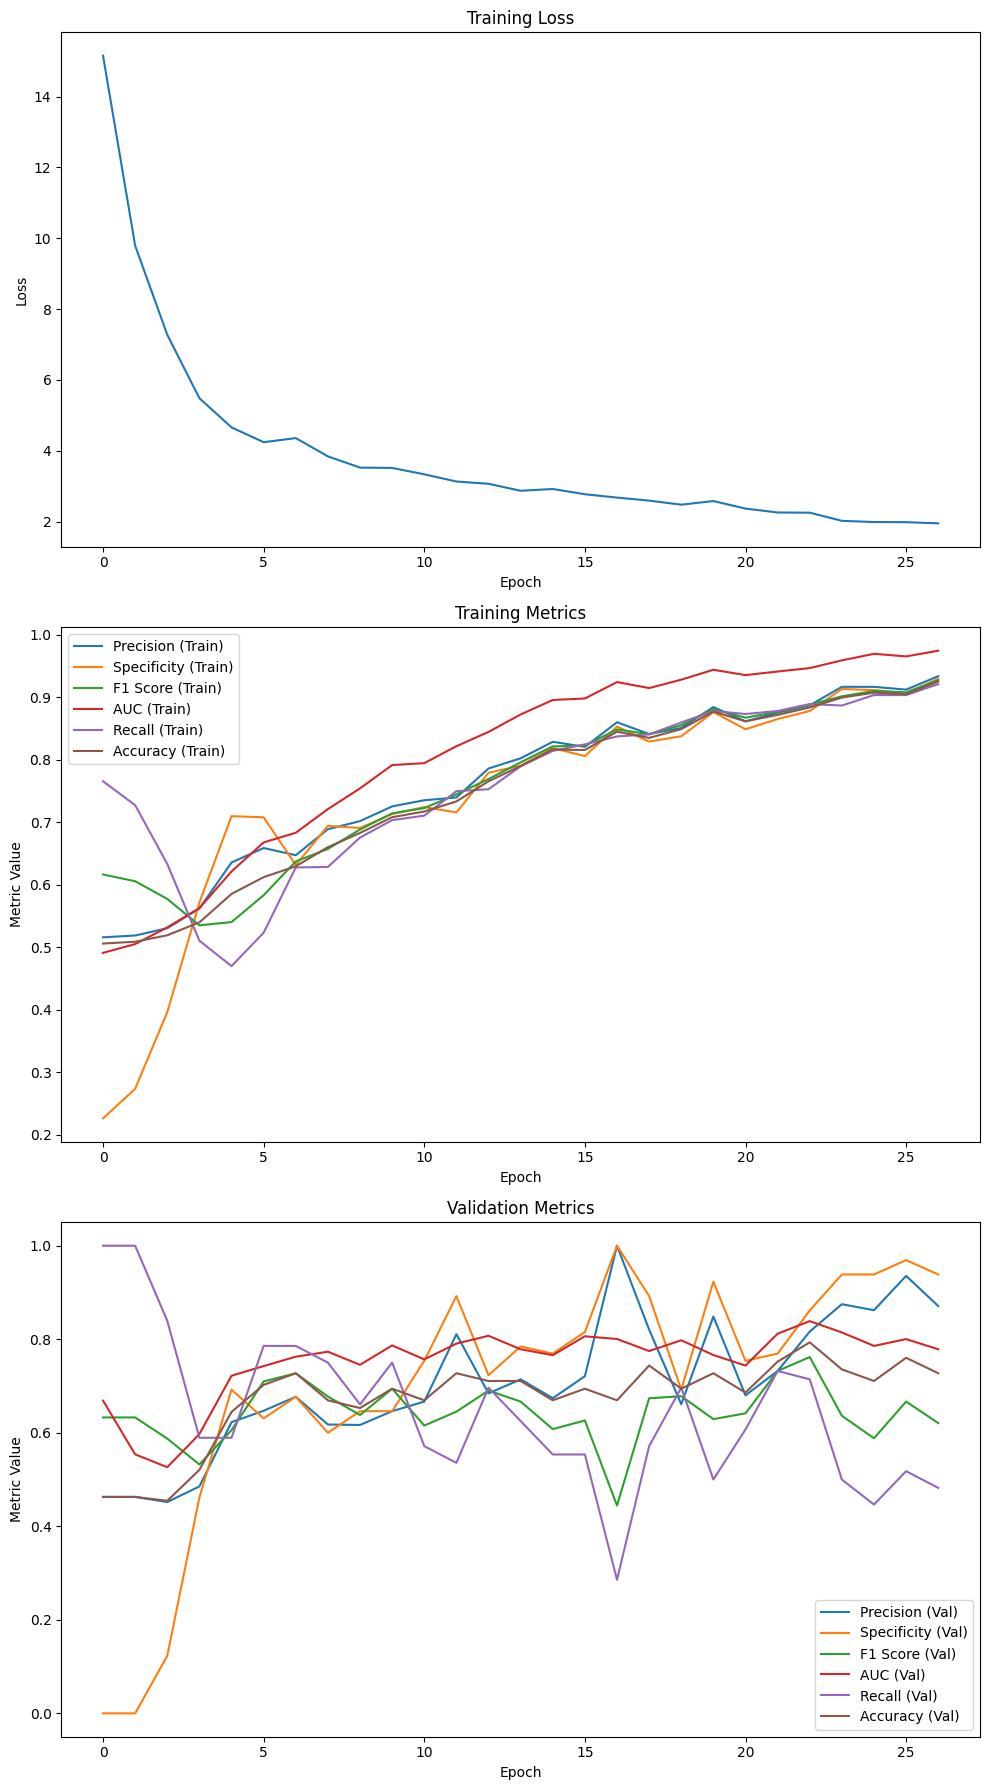

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tqdm import tqdm
import os
import time


config = Config()
model = ConvNeXtV2MAE(config).to(config.device)

optimizer = optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

start_epoch = 0
best_val_metrics = 0.0
best_val_precision = 0.0
best_val_specificity = 0.0
best_val_f1 = 0.0
best_val_auc = 0.0
best_val_recall = 0.0
best_val_accuracy = 0.0
counter = 0
train_losses = []
train_precisions = []
train_specificities = []
train_f1s = []
train_aucs = []
train_recalls = []
train_accuracies = []
val_precisions = []
val_specificities = []
val_f1s = []
val_aucs = []
val_recalls = []
val_accuracies = []

checkpoint_path = os.path.join(config.save_dir, 'checkpoint.pth')
best_model_dir = config.save_dir
os.makedirs(best_model_dir, exist_ok=True)

if config.resume_training:
    checkpoint = torch.load(config.best_model_path, map_location=config.device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_precision = checkpoint['best_val_precision']
    best_val_specificity = checkpoint['best_val_specificity']
    best_val_f1 = checkpoint.get('best_val_f1', 0.0)
    best_val_auc = checkpoint.get('best_val_auc', 0.0)
    best_val_recall = checkpoint.get('best_val_recall', 0.0)
    best_val_accuracy = checkpoint.get('best_val_accuracy', 0.0)
    train_losses = checkpoint.get('train_losses', [])
    train_precisions = checkpoint.get('train_precisions', [])
    train_specificities = checkpoint.get('train_specificities', [])
    train_f1s = checkpoint.get('train_f1s', [])
    train_aucs = checkpoint.get('train_aucs', [])
    train_recalls = checkpoint.get('train_recalls', [])
    train_accuracies = checkpoint.get('train_accuracies', [])
    val_precisions = checkpoint.get('val_precisions', [])
    val_specificities = checkpoint.get('val_specificities', [])
    val_f1s = checkpoint.get('val_f1s', [])
    val_aucs = checkpoint.get('val_aucs', [])
    val_recalls = checkpoint.get('val_recalls', [])
    val_accuracies = checkpoint.get('val_accuracies', [])

for epoch in range(start_epoch, config.num_epochs):
    model.train()
    epoch_loss = 0.0
    all_mae = []
    all_cls = []
    all_preds = []
    all_labels = []
    all_probs = []
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.num_epochs}')
    
    for i, (c_img, w_img, labels) in enumerate(progress_bar):
        c_img, w_img, labels = c_img.to(config.device), w_img.to(config.device), labels.to(config.device)
        optimizer.zero_grad(set_to_none=True)
        loss_dict, _, _, cls_pred = model(c_img, w_img, labels)
        loss = loss_dict['total_loss']
        loss.backward()
        optimizer.step()
        
        probs = torch.softmax(cls_pred, dim=1)[:, 1].detach()
        preds = torch.argmax(cls_pred, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        epoch_loss += loss.item()
        all_mae.append(loss_dict['mae_loss'].item())
        all_cls.append(loss_dict['cls_loss'].item())
        
        if (i+1) % 20 == 0 or i == len(train_loader)-1:
            cls = loss_dict['cls_loss'].item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}", cls=f"{cls:.4f}", mae=f"{loss_dict['mae_loss'].item():.4f}")
    
    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)
    avg_cls = np.mean(all_cls)
    avg_mae = np.mean(all_mae)
    train_precision = precision_score(all_labels, all_preds)
    train_recall = recall_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds)
    train_auc = roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else 0.0
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()
    train_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    train_accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0

    train_precisions.append(train_precision)
    train_specificities.append(train_specificity)
    train_f1s.append(train_f1)
    train_aucs.append(train_auc)
    train_recalls.append(train_recall)
    train_accuracies.append(train_accuracy)
    
    print(f"\nEpoch {epoch+1} - Train: cls={avg_cls:.4f}, mae={avg_mae:.4f}, loss={train_loss:.4f}, "
          f"precision={train_precision:.4f}, specificity={train_specificity:.4f}, "
          f"recall={train_recall:.4f}, f1={train_f1:.4f}, auc={train_auc:.4f}, accuracy={train_accuracy:.4f}")

    model.eval()
    all_preds, all_labels, all_probs, all_mae_val, all_cls_val = [], [], [], [], []
    with torch.no_grad():
        for c_img, w_img, labels in val_loader:
            c_img, w_img, labels = c_img.to(config.device), w_img.to(config.device), labels.to(config.device)
            loss_dict, pred, mask, cls_pred = model(c_img, w_img, labels)
            probs = torch.softmax(cls_pred, dim=1)[:, 1]
            preds = torch.argmax(cls_pred, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_mae_val.append(loss_dict['mae_loss'].item())
            all_cls_val.append(loss_dict['cls_loss'].item())

    avg_cls_val = np.mean(all_cls_val)
    avg_mae_val = np.mean(all_mae_val)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else 0.0
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0

    val_precisions.append(precision)
    val_specificities.append(specificity)
    val_f1s.append(f1)
    val_aucs.append(auc)
    val_recalls.append(recall)
    val_accuracies.append(accuracy)
    
    print(f"Epoch {epoch+1} - Val: cls={avg_cls_val:.4f}, mae={avg_mae_val:.4f}, "
          f"precision={precision:.4f}, specificity={specificity:.4f}, "
          f"recall={recall:.4f}, f1={f1:.4f}, auc={auc:.4f}, accuracy={accuracy:.4f}")

    composite_metric = 0.4 * precision + 0.6 * specificity
    scheduler.step(composite_metric)

    is_best = composite_metric > best_val_metrics
    if is_best:
        best_val_metrics = composite_metric
        best_val_precision = precision
        best_val_specificity = specificity
        best_val_f1 = f1
        best_val_auc = auc
        best_val_recall = recall
        best_val_accuracy = accuracy
        counter = 0
        model_path = os.path.join(best_model_dir,
                                 f"best_model_p{precision:.4f}_s{specificity:.4f}_f1{f1:.4f}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"★ Saved best model: {os.path.basename(model_path)}")
    else:
        counter += 1

    if (epoch+1) % 5 == 0 or is_best:
        checkpoint = {
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_precision': best_val_precision,
            'best_val_specificity': best_val_specificity,
            'best_val_f1': best_val_f1,
            'best_val_auc': best_val_auc,
            'best_val_recall': best_val_recall,
            'best_val_accuracy': best_val_accuracy,
            'train_losses': train_losses,
            'train_precisions': train_precisions,
            'train_specificities': train_specificities,
            'train_f1s': train_f1s,
            'train_aucs': train_aucs,
            'train_recalls': train_recalls,
            'train_accuracies': train_accuracies,
            'val_precisions': val_precisions,
            'val_specificities': val_specificities,
            'val_f1s': val_f1s,
            'val_aucs': val_aucs,
            'val_recalls': val_recalls,
            'val_accuracies': val_accuracies,
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1}")

    if counter >= config.patience:
        print(f"Early stopping at epoch {epoch+1}: No improvement in composite metric for {config.patience} epochs")
        break

print(f"Training completed. Best metrics: precision={best_val_precision:.4f}, specificity={best_val_specificity:.4f}, "
      f"f1={best_val_f1:.4f}, auc={best_val_auc:.4f}, recall={best_val_recall:.4f}, accuracy={best_val_accuracy:.4f}")

def plot_training_metrics(train_losses, train_precisions, train_specificities, train_f1s, train_aucs, train_recalls, train_accuracies,
                         val_precisions, val_specificities, val_f1s, val_aucs, val_recalls, val_accuracies):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18))
    
    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    
    ax2.plot(train_precisions, label='Precision (Train)')
    ax2.plot(train_specificities, label='Specificity (Train)')
    ax2.plot(train_f1s, label='F1 Score (Train)')
    ax2.plot(train_aucs, label='AUC (Train)')
    ax2.plot(train_recalls, label='Recall (Train)')
    ax2.plot(train_accuracies, label='Accuracy (Train)')
    ax2.set_title('Training Metrics')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Metric Value')
    ax2.legend()
    
    ax3.plot(val_precisions, label='Precision (Val)')
    ax3.plot(val_specificities, label='Specificity (Val)')
    ax3.plot(val_f1s, label='F1 Score (Val)')
    ax3.plot(val_aucs, label='AUC (Val)')
    ax3.plot(val_recalls, label='Recall (Val)')
    ax3.plot(val_accuracies, label='Accuracy (Val)')
    ax3.set_title('Validation Metrics')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Metric Value')
    ax3.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.save_dir, 'metrics.png'))
    plt.show()

plot_training_metrics(train_losses, train_precisions, train_specificities, train_f1s, train_aucs, train_recalls, train_accuracies,
                     val_precisions, val_specificities, val_f1s, val_aucs, val_recalls, val_accuracies)